# Milky-way analogue subject upload

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import re
import getpass
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import panoptes_client
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import match_coordinates_sky
from astropy import log
from tqdm import tqdm
from panoptes_client import SubjectSet, Subject, Project, Panoptes
import sdssCutoutGrab as scg
import subjectCreator as subC

In [3]:
# log.setLevel('ERROR')

The MWA galaxy info provided can be seen below. The dataframe is called `mwa_df`

In [4]:
mwa_df = pd.DataFrame([
    ('8137-12703', 116.16926, 44.144409, 'https://dr15.sdss.org/marvin/galaxy/8137-12703/'),
    ('8141-12701', 116.73264, 44.265699, 'https://dr15.sdss.org/marvin/galaxy/8141-12701/'),
    ('8567-6101', 119.14512, 47.563851, 'https://dr15.sdss.org/marvin/galaxy/8567-6101/'),
    ('9486-12702', 121.12960, 40.206045, 'https://dr15.sdss.org/marvin/galaxy/9486-12702/'),
    ('9487-12701', 122.52287, 46.193025, 'https://dr15.sdss.org/marvin/galaxy/9487-12701/'),
    ('8244-6101', 130.45491, 50.786425, 'https://dr15.sdss.org/marvin/galaxy/8244-6101/'),
    ('9028-9101', 243.02559, 28.498866, 'https://dr15.sdss.org/marvin/galaxy/9028-9101/'),
    ('8595-3702', 219.04276, 50.518822, 'https://dr15.sdss.org/marvin/galaxy/8595-3702/'),
    ('8549-3703', 241.41644, 46.846561, 'https://dr15.sdss.org/marvin/galaxy/8549-3703/'),
    ('9031-12703', 242.81922, 45.121318, 'https://dr15.sdss.org/marvin/galaxy/9031-12703/'),
    ('9868-12705', 218.87457, 46.202391, 'https://dr15.sdss.org/marvin/galaxy/9868-12705/'),
    ('8979-9101', 241.27859, 42.037358, 'https://dr15.sdss.org/marvin/galaxy/8979-9101/'),
    ('8979-6102', 241.82339, 41.403604, 'https://dr15.sdss.org/marvin/galaxy/8979-6102/'),
    ('8315-12705', 235.92049, 39.540357, 'https://dr15.sdss.org/marvin/galaxy/8315-12705/'),
    ('8934-12701', 196.16279, 28.628904, 'https://dr15.sdss.org/marvin/galaxy/8934-12701/'),
    ('8319-6102', 199.94477, 48.206576, 'https://dr15.sdss.org/marvin/galaxy/8319-6102/'),
    ('8444-12703', 201.41111, 33.680433, 'https://dr15.sdss.org/marvin/galaxy/8444-12703/'),
    ('8985-9102', 205.87340, 31.003218, 'https://dr15.sdss.org/marvin/galaxy/8985-9102/'),
    ('8241-3704', 126.56891, 17.362452, 'https://dr15.sdss.org/marvin/galaxy/8241-3704/'),
    ('8146-12702', 116.83569, 29.412934, 'https://dr15.sdss.org/marvin/galaxy/8146-12702/'),
    ('9491-12704', 119.53574, 19.550146, 'https://dr15.sdss.org/marvin/galaxy/9491-12704/'),
    ('9506-3701', 133.56990, 27.266526, 'https://dr15.sdss.org/marvin/galaxy/9506-3701/'),
    ('8613-12702', 254.04414, 34.836520, 'https://dr15.sdss.org/marvin/galaxy/8613-12702/'),
    ('8568-6103', 155.37679, 38.308947, 'https://dr15.sdss.org/marvin/galaxy/8568-6103/'),
    ('8263-6104', 187.28568, 46.881492, 'https://dr15.sdss.org/marvin/galaxy/8263-6104/'),
    ('8257-12705', 167.03456, 45.984624, 'https://dr15.sdss.org/marvin/galaxy/8257-12705/'),
    ('8947-12703', 172.88669, 49.857504, 'https://dr15.sdss.org/marvin/galaxy/8947-12703/'),
    ('9095-9102', 243.08489, 23.002020, 'https://dr15.sdss.org/marvin/galaxy/9095-9102/'),
    ('8615-9102', 321.47404, 0.41605877, 'https://dr15.sdss.org/marvin/galaxy/8615-9102/'),
    ('9196-9101', 262.65063, 54.101229, 'https://dr15.sdss.org/marvin/galaxy/9196-9101/'),
    ('9196-6104', 262.31772, 54.205924, 'https://dr15.sdss.org/marvin/galaxy/9196-6104/'),
    ('8244-9101', 133.78758, 52.470442, 'https://dr15.sdss.org/marvin/galaxy/8244-9101/'),
], columns=('Plate IFU', 'ra', 'dec', 'Marvin URL'))
mwa_df.head(3)

,Plate IFU,ra,dec,Marvin URL
0,8137-12703,116.16926,44.144409,https://dr15.sdss.org/marvin/galaxy/8137-12703/
1,8141-12701,116.73264,44.265699,https://dr15.sdss.org/marvin/galaxy/8141-12701/
2,8567-6101,119.14512,47.563851,https://dr15.sdss.org/marvin/galaxy/8567-6101/


In [5]:
mwa_coords = SkyCoord(
    ra=mwa_df['ra'].values * u.degree,
    dec=mwa_df['dec'].values * u.degree,
)

We'll load in the NSA catalog for cross-matching

In [6]:
nsa_cat = fits.open('../source_files/nsa_v1_0_1.fits')

And use `astropy` to match based on sky position (with a search radius of 36")

In [7]:
nsa_coords = SkyCoord(
    ra=nsa_cat[1].data['RA'] * u.degree,
    dec=nsa_cat[1].data['DEC'] * u.degree,
)
jsFull, sep2d, d3d = match_coordinates_sky(mwa_coords, nsa_coords)
jsMask = np.logical_not(sep2d > 0.01*u.degree)
js = jsFull[jsMask]

In [8]:
keys = (
    'RA', 'DEC', 'Z', 'ZDIST',
    'ISDSS', 'INED', 'NSAID', 'IAUNAME',
    'RUN', 'CAMCOL', 'FIELD', 'RERUN',
    'PETRO_THETA', 'SERSIC_BA',
)
nsa_match = pd.DataFrame(
    {k: nsa_cat[1].data[jsFull][k] for k in keys}
).rename(columns={
    'RA': 'ra', 'DEC': 'dec', 'Z': 'z',
    'ISDSS': 'dr7objid', 'PETRO_THETA': 'petrotheta',
})
nsa_match.head()

,ra,dec,z,ZDIST,dr7objid,INED,NSAID,IAUNAME,RUN,CAMCOL,FIELD,RERUN,petrotheta,SERSIC_BA
0,116.169257,44.144409,0.038287,0.038538,363870,49353,358532,J074440.61+440839.8,4204,3,74,301,17.100700,0.659336
1,116.732642,44.265699,0.031231,0.031481,363844,49652,358506,J074655.82+441556.5,1402,6,82,301,15.874659,0.347331
2,119.145124,47.563851,0.069156,0.069443,377430,-1,372092,J075634.82+473349.8,4204,3,101,301,13.001850,0.646143
3,121.129595,40.206045,0.040257,0.040417,79044,52785,76547,J080431.10+401221.7,2076,3,111,301,23.426533,0.770208
4,122.522873,46.193025,0.031603,0.031851,47980,53716,47513,J081005.48+461134.8,1331,6,134,301,27.340874,0.815644


We'll load the GZ2 catalog and cross match too

In [9]:
gz2_cat = fits.open('../source_files/NSA_GalaxyZoo.fits')

In [10]:
gz2_coords = SkyCoord(
    ra=nsa_cat[1].data['RA'] * u.degree,
    dec=nsa_cat[1].data['DEC'] * u.degree,
)
jsFull, sep2d, d3d = match_coordinates_sky(mwa_coords, nsa_coords)
jsMask = np.logical_not(sep2d > 0.01*u.degree)
js = jsFull[jsMask]
gz2_match = nsa_cat[1].data[jsFull]

## File creation
We need a greyscale image, a model json file and a difference json file for each image. This will be created using `subjectCreator`

In [11]:
shouldCreateFiles = True

In [12]:
log.setLevel('ERROR')

In [13]:
if shouldCreateFiles:
  files, success, err, montageFailures = [], [], [], []
  with tqdm(nsa_match.iterrows(), total=len(nsa_match)) as bar:
    for i, gal in bar:
      extra_meta = {
        'Plate IFU': mwa_df.iloc[i]['Plate IFU'],
        'Marvin URL': "[View on Marvin](+tab+{})".format(
          mwa_df.iloc[i]['Marvin URL'],
        ),
      }
      res = subC.pipeline(
        gal,
        outputFolder='subject_sets/mwa_subject_set',
        subjectName='subject{}'.format(i),
        extra_metadata=extra_meta,
        verbose=False
      )
      if res:
        success += [i]
        files += [res]
      else:
        montageFailures += [i]
else:
  nSubjects = len([
    f for f in os.listdir('subject_sets/mwa_subject_set')
    if not '.DS' in f
  ])/4
  files = [
    (
      'subject_sets/mwa_subject_set/image_subject{}.png'.format(i),
      'subject_sets/mwa_subject_set/model_subject{}.json'.format(i),
      'subject_sets/mwa_subject_set/difference_subject{}.json'.format(i),
    )
    for i in range(nSubjects)
  ]
  err = []

100%|██████████| 32/32 [07:04<00:00, 15.53s/it]


Check all the files in our file list exist:

In [14]:
assert all(os.path.exists(j) for i in files for j in i)

In [15]:
print('Number of subjects:', len(files))
print('Failed subjects:', len(err))

Number of subjects: 32
Failed subjects: 0


Let's have a look at one of the galaxies!

mwa_subject_set/difference_subject20.json


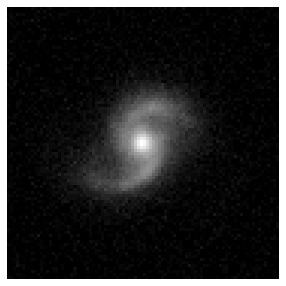

In [16]:
from astropy.visualization import AsinhStretch
s_to_view = 'mwa_subject_set/difference_subject{}.json'.format(
    np.random.randint(0, len(files))
)
print(s_to_view)
with open(s_to_view) as f:
    diffData = json.load(f)
im = AsinhStretch()(np.array(diffData['imageData']))
plt.figure(figsize=(5, 5))
plt.imshow(im, cmap='gray')
plt.axis('off');

# Upload to the Zooniverse

We've made our subject set, now to send it on its merry way, use 

`python uploadSubjects.py mwa_subject_set milky_way_analogs`

(as an admin)